In [11]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle

import seaborn as sns
sns.color_palette("hls", 17)
#import scipy.stats as st
import math
from tqdm.notebook import tqdm
from pingouin import rcorr
import pingouin as pg

import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor, AdaBoostRegressor
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn import svm 
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, plot_roc_curve, roc_curve, auc, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import feature_selection #import chi2

In [12]:
import sys
import os
sys.path.append(os.path.join(".."))

from module.trend_analysis_functions import *
from module.topic_model_plus_class import Topic_Model_plus

In [13]:
test_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_data','ICS_predictive_sitreps_full_test.csv')).drop(["Unnamed: 0"], axis=1)
train_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_data','ICS_predictive_sitreps_full_train.csv')).drop(["Unnamed: 0"], axis=1)
val_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_data','ICS_predictive_sitreps_full_val.csv')).drop(["Unnamed: 0"], axis=1)

In [14]:
train_data

,CY,DISCOVERY_DATE,INCIDENT_ID,PCT_CONTAINED_COMPLETED,START_YEAR,TOTAL_AERIAL,TOTAL_PERSONNEL,REPORT_DOY,DISCOVERY_DOY,Combined_Text,...,INC_MGMT_ORG_ABBREV_2,INC_MGMT_ORG_ABBREV_3,INC_MGMT_ORG_ABBREV_4,INC_MGMT_ORG_ABBREV_5,INC_MGMT_ORG_ABBREV_A,INC_MGMT_ORG_ABBREV_B,INC_MGMT_ORG_ABBREV_C,INC_MGMT_ORG_ABBREV_D,INC_MGMT_ORG_ABBREV_E,INC_MGMT_ORG_ABBREV_F
0,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,0.000017,2010,0.052083,0.043860,197,196,"['resource', 'share', 'cactus']",...,0,0,1,0,0,0,0,0,0,0
1,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,0.000012,2010,0.052083,0.043860,197,196,"['resource', 'share', 'incident', 'cactus', 'i...",...,0,0,1,0,0,0,0,0,0,0
2,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,0.000006,2010,0.041667,0.031465,197,196,"['resource', 'share', 'cactus', 'erratic', 'wi...",...,0,0,1,0,0,0,0,0,0,0
3,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,0.000021,2010,0.045139,0.036677,197,196,"['resource', 'share', 'cactus', 'cactus', 'bec...",...,0,0,1,0,0,0,0,0,0,0
4,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,0.000012,2010,0.045139,0.036677,197,196,"['resource', 'share', 'cactus', 'cactus', 'bec...",...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39352,2014,4/11/2014 17:00,2014_N041114-22_CHIMNEY TOP FIRE,0.000021,2014,0.000000,0.000191,106,101,"['rain', 'fell', 'hour', 'everything']",...,0,0,0,1,0,0,0,0,0,0
39353,2014,3/10/2014 14:00,2014_VA-VAS 0140633_OVER YONDER FIRE,0.000021,2014,0.000000,0.001812,71,69,"['acre', 'revise', 'downward', 'result', 'actu...",...,0,0,0,1,0,0,0,0,0,0
39354,2014,3/10/2014 14:00,2014_VA-VAS 0140633_OVER YONDER FIRE,0.000021,2014,0.000000,0.001812,71,69,"['acre', 'revise', 'downward', 'result', 'actu...",...,0,0,0,1,0,0,0,0,0,0
39355,2014,4/20/2014 9:00,2014_VAS1400605_ISSAC'S BRANCH,0.000008,2014,0.000000,0.003623,113,110,"['flame', 'length', 'steep', 'limited', 'access']",...,0,0,0,1,0,0,0,0,0,0


In [15]:
summary_reps = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_data','ICS_predictive_summaryreps_full.csv')).drop(["Unnamed: 0"], axis=1)#os.path.join(os.path.dirname(os.getcwd()),'data','summary_reports_cleaned.csv')).drop(["Unnamed: 0"], axis=1)

C:\Users\srandrad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3251: DtypeWarning: Columns (7,13,18,19,36) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
ids = list(train_data["INCIDENT_ID"].unique()) + list(test_data['INCIDENT_ID'].unique())+list(val_data['INCIDENT_ID'].unique())
print(len(ids))
summary_reps = summary_reps.loc[summary_reps["INCIDENT_ID"].isin(ids)].reset_index(drop=True)
len(summary_reps)

8973


8973

In [17]:
train_data.columns

Index(['CY', 'DISCOVERY_DATE', 'INCIDENT_ID', 'PCT_CONTAINED_COMPLETED',
       'START_YEAR', 'TOTAL_AERIAL', 'TOTAL_PERSONNEL', 'REPORT_DOY',
       'DISCOVERY_DOY', 'Combined_Text', 'Unique_IDs', 'Raw_Combined_Text',
       'ACRES', 'WF_FSR', 'INJURIES', 'FATALITIES', 'EST_IM_COST_TO_DATE',
       'STR_DAMAGED', 'STR_DESTROYED', 'NEW_ACRES', 'POO_STATE',
       'POO_LATITUDE', 'POO_LONGITUDE', 'WEATHER_CONCERNS_NARR',
       'INC_MGMT_ORG_ABBREV', 'EVACUATION_IN_PROGRESS', 'Incident_region',
       'NUM_REPORTS', 'DAYS_BURING', 'Severity', 'Traffic',
       'Command_Transitions', 'Evacuations', 'Inaccurate_Mapping',
       'Aerial_Grounding', 'Resource_Issues', 'Injuries', 'Cultural_Resources',
       'Livestock', 'Law_Violations', 'Military_Base', 'Infrastructure',
       'Extreme_Weather', 'Ecological', 'Hazardous_Terrain', 'Floods',
       'Dry_Weather', 'Total_Incident_Text', 'Current_total_Injuries',
       'Current_total_Structures_Damages',
       'Current_total_Structures_Des

In [18]:
xcols = ['TOTAL_AERIAL', 'TOTAL_PERSONNEL', 'WF_FSR', 'DAYS_BURING', 'ACRES','PCT_CONTAINED_COMPLETED', #'Current_total_Injuries',
       #'Current_total_Structures_Damages',
       #'Current_total_Structures_Destroyed', 'Current_total_Fatalities',
         'INJURIES','FATALITIES', 'STR_DESTROYED','STR_DAMAGED', 'Traffic',
       'Command_Transitions', 'Evacuations', 'Inaccurate_Mapping',
       'Aerial_Grounding', 'Resource_Issues', 'Injuries', 'Cultural_Resources',
       'Livestock', 'Law_Violations', 'Military_Base', 'Infrastructure',
       'Extreme_Weather', 'Ecological', 'Hazardous_Terrain', 'Floods',
       'Dry_Weather', 'Incident_region_AICC', 'Incident_region_CA', 'Incident_region_EACC',
       'Incident_region_GBCC', 'Incident_region_HICC', 'Incident_region_NRCC',
       'Incident_region_NWCC', 'Incident_region_RMCC', 'Incident_region_SACC',
       'Incident_region_SWCC']
ycols = ['Total_Injuries', 'Total_Structures_Damages', 'Total_Structures_Destroyed',
       'Total_Fatalities']# ['Diff_Injuries', 'Diff_Structures_Damages', 'Diff_Structures_Destroyed','Diff_Fatalities']
Xtrain = train_data[xcols]; ytrain = train_data[ycols]
Xval = val_data[xcols]; yval = val_data[ycols]
Xtest = test_data[xcols]; ytest = test_data[ycols]

In [19]:
Xtrain.shape

(39357, 37)

In [20]:
Xval.shape

(4800, 37)

Models to test:
- SVM
- NB
- Logistic Regression
- Random Forest
- xgboost
- AdaBoost
- NN

In [22]:
train_test = pd.concat([Xtrain,Xtest])
ytrain_test = pd.concat([ytrain,ytest])
model_names = ["SVM", "GradientBoosting", "Random Forest", "Bayesian Ridge", "MLP", "XGBoost", "AdaBoost", "Decision Tree"]
cols = {(str(score),str(model),str(metric)):[] for score in ["MSE","R^2"] for model in ["train","test"] for metric in ['injuries','str dam', 'str des', 'fatalities', 'average']}

models = [svm.SVR(kernel='rbf', C=1.2), GradientBoostingRegressor(max_features='log2',n_estimators=150, random_state=0, max_depth=22,criterion='squared_error'), 
          RandomForestRegressor(criterion='squared_error',max_features='auto',n_estimators=175, random_state=0, max_depth=4),
          linear_model.BayesianRidge(alpha_1=100, alpha_2=10000, lambda_1=100, lambda_2=100),
          MLPRegressor(random_state=0, max_iter=10000, alpha=0.1, learning_rate='constant', hidden_layer_sizes= (100,)), xgb.XGBRegressor(booster='gblinear',n_estimators=150),
         AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae', max_features='sqrt', splitter='random'), n_estimators=50, learning_rate=0.1, loss='exponential'), 
         DecisionTreeRegressor(criterion='mae', max_features='sqrt', splitter='random')]
for m in tqdm(models):
    mdl = MultiOutputRegressor(m)
    mdl.fit(train_test, ytrain_test)
    train_pred = np.around(mdl.predict(train_test)); train_pred[train_pred<0] = 0
    val_pred = np.around(mdl.predict(Xval)); val_pred[val_pred<0] = 0

    train_score = np.around(r2_score(ytrain_test, train_pred, multioutput='raw_values'),3)
    cols[('R^2','train','injuries')].append(train_score[0]); cols[('R^2', 'train', 'str dam')].append(train_score[1])
    cols[('R^2','train','str des')].append(train_score[2]); cols[('R^2', 'train', 'fatalities')].append(train_score[3])
    cols[('R^2','train','average')].append(round(r2_score(ytrain_test, train_pred),3))
    
    test_score = np.around(r2_score(yval, val_pred,multioutput='raw_values'),3)
    cols[('R^2','test','injuries')].append(test_score[0]); cols[('R^2','test','str dam')].append(test_score[1])
    cols[('R^2','test','str des')].append(test_score[2]); cols[('R^2','test','fatalities')].append(test_score[3])
    cols[('R^2','test','average')].append(round(r2_score( yval, val_pred),3))
    
    train_MSE = np.around(mean_squared_error( ytrain_test, train_pred,multioutput='raw_values'),3)
    cols[('MSE','train','injuries')].append(train_MSE[0]); cols[('MSE', 'train', 'str dam')].append(train_MSE[1])
    cols[('MSE','train','str des')].append(train_MSE[2]); cols[('MSE', 'train', 'fatalities')].append(train_MSE[3])
    cols[('MSE','train','average')].append(round(mean_squared_error(  ytrain_test,train_pred),3))
    
    test_MSE = np.around(mean_squared_error(yval, val_pred,multioutput='raw_values'),3)
    cols[('MSE','test','injuries')].append(test_MSE[0]); cols[('MSE','test','str dam')].append(test_MSE[1])
    cols[('MSE','test','str des')].append(test_MSE[2]); cols[('MSE','test','fatalities')].append(test_MSE[3])
    cols[('MSE','test','average')].append(round(mean_squared_error(yval,val_pred),3))
    
columns = pd.MultiIndex.from_tuples([col for col in cols])
results_df = pd.DataFrame(cols, columns=columns, index=model_names)
results_df

 12%|██████████▏                                                                      | 1/8 [14:56<1:44:35, 896.56s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:471: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `cri

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tr

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tr

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tr

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tr

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tr

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tr

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tr

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tr

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tr

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tr

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tr

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tr

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tr

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tr

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tr

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\tr

MSE                                                   \
                    train                                             test   
                 injuries  str dam   str des fatalities   average injuries   
SVM                19.129  286.406  4695.516      0.054  1250.276    9.445   
GradientBoosting    0.000    0.000     0.000      0.000     0.000   11.789   
Random Forest      20.467   38.128   296.932      0.149    88.919   11.856   
Bayesian Ridge     25.917   98.123   531.151      0.250   163.860   14.378   
MLP                 6.293   13.412   123.547      0.032    35.821   34.470   
XGBoost            25.897   98.125   531.218      0.250   163.873   14.506   
AdaBoost            0.000    0.058    40.606      0.000    10.166   17.035   
Decision Tree       0.000    0.000   812.332      0.000   203.083   28.227   

                                                             R^2          \
                                                           train           
                  str dam   str des fatalities  average injuries str dam   
SVM                97.518  1340.114      0.057  361.783    0.587   0.095   
GradientBoosting   35.835   294.424      0.048   85.524    1.000   1.000   
Random Forest      26.571   270.932      0.024   77.346    0.558   0.879   
Bayesian Ridge     26.312   236.481      0.042   69.303    0.440   0.690   
MLP                35.472   647.119      0.045  179.277    0.864   0.958   
XGBoost            26.309   236.591      0.042   69.362    0.441   0.690   
AdaBoost           30.245   590.904      0.022  159.552    1.000   1.000   
Decision Tree     101.155  2851.853      0.128  745.341    1.000   1.000   

                                                                      \
                                                test                   
                 str des fatalities average injuries str dam str des   
SVM                0.052      0.897   0.408    0.236   0.041   0.036   
GradientBoosting   1.000      1.000   1.000    0.047   0.648   0.788   
Random Forest      0.940      0.716   0.773    0.041   0.739   0.805   
Bayesian Ridge     0.893      0.522   0.636   -0.163   0.741   0.830   
MLP                0.975      0.939   0.934   -1.787   0.651   0.534   
XGBoost            0.893      0.522   0.636   -0.173   0.741   0.830   
AdaBoost           0.992      1.000   0.998   -0.377   0.703   0.575   
Decision Tree      0.836      1.000   0.959   -1.283   0.005  -1.052   

                                     
                                     
                 fatalities average  
SVM                   0.334   0.162  
GradientBoosting      0.448   0.483  
Random Forest         0.719   0.576  
Bayesian Ridge        0.511   0.480  
MLP                   0.482  -0.030  
XGBoost               0.511   0.477  
AdaBoost              0.741   0.410  
Decision Tree        -0.483  -0.703

In [24]:
cols_to_keep = [('MSE', 'train', 'average'),('MSE', 'test', 'average'), ('R^2', 'train', 'average'), ('R^2', 'test', 'average')]
cols_to_drop = [col for col in results_df.columns if col not in cols_to_keep]
condensed_results = results_df.drop(cols_to_drop, axis=1)
condensed_results.to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n{} & \\multicolumn{2}{l}{MSE} & \\multicolumn{2}{l}{R\\textasciicircum 2} \\\\\n{} &     train &     test &   train &    test \\\\\n{} &   average &  average & average & average \\\\\n\\midrule\nSVM              &  1250.276 &  361.783 &   0.408 &   0.162 \\\\\nGradientBoosting &     0.000 &   85.524 &   1.000 &   0.483 \\\\\nRandom Forest    &    88.919 &   77.346 &   0.773 &   0.576 \\\\\nBayesian Ridge   &   163.860 &   69.303 &   0.636 &   0.480 \\\\\nMLP              &    35.821 &  179.277 &   0.934 &  -0.030 \\\\\nXGBoost          &   163.873 &   69.362 &   0.636 &   0.477 \\\\\nAdaBoost         &    10.166 &  159.552 &   0.998 &   0.410 \\\\\nDecision Tree    &   203.083 &  745.341 &   0.959 &  -0.703 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [21]:
m = xgb.XGBRegressor(booster='gblinear',n_estimators=150)
#m = RandomForestRegressor(criterion='mse',max_features='auto',n_estimators=175, random_state=0, max_depth=4)
mdl = MultiOutputRegressor(m)
train_test = pd.concat([Xtrain,Xtest])
ytrain_test = pd.concat([ytrain,ytest])
mdl.fit(train_test, ytrain_test)
#preds = np.around(mdl.predict(Xtest))
#preds[preds<0]=0

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster='gblinear',
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=150, n_jobs=None,
                                            num_parallel_tree=None,

In [22]:
#preds = pd.DataFrame(preds, columns = ytest.columns)
val_pred = np.around(mdl.predict(Xval)); val_pred[val_pred<0] = 0
test_score = np.around(r2_score(val_pred, yval,multioutput='raw_values'),3)
test_MSE = np.around(mean_squared_error(yval, val_pred,multioutput='raw_values'),3)
print(test_score, test_MSE)
print(np.round(r2_score(val_pred, yval),3))
print(round(mean_squared_error(val_pred, yval),3))

[0.291 0.637 0.818 0.532] [1.45060e+01 2.63090e+01 2.36591e+02 4.20000e-02]
0.569
69.362


In [13]:
np.unique(val_pred)

array([ -0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  42.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  60.,  63.,  76.,  81.,  94., 112., 113., 114., 115.,
       116., 119., 120., 123., 124., 125., 126., 128., 131., 132., 133.,
       134., 135., 136., 137., 138., 139., 140., 141., 142., 143., 145.,
       146., 147., 148., 150., 151., 152., 153., 154., 155., 156., 157.,
       158., 159., 160., 164., 167., 170., 172., 174., 175., 176., 186.,
       229., 230., 231., 233., 238., 244., 247., 249., 251., 252., 253.,
       254., 300., 306., 307., 308., 309., 310., 311., 316., 317., 318.,
       326., 332., 333., 398.], dtype=float32)

In [14]:
pd.DataFrame(val_pred,columns=['inj', 'str dam', 'str des', 'fat'])['str des'].sum()

45227.0

In [15]:
yval['Total_Structures_Destroyed'].sum()

41454.0

In [16]:
filename = os.path.join(os.path.dirname(os.getcwd()),'models','severity_model_xGB.sav')
pickle.dump(mdl, open(filename, 'wb'))

# Hyper parameter tuning

## SVM

In [14]:
kernals = ['rbf', 'poly', 'sigmoid']
train_r = []
test_r = []
train_MSE = []
test_MSE = []
for kernal in kernals:
    print(kernal)
    mdl = MultiOutputRegressor(svm.SVR(kernel=kernal))
    
    mdl.fit(Xtrain, ytrain)
    train_r.append(round(mdl.score(Xtrain, ytrain),3))
    test_r.append(round(mdl.score(Xtest, ytest),3))
    train_MSE.append(round(mean_squared_error(ytrain, mdl.predict(Xtrain)),3))
    test_MSE.append(round(mean_squared_error(ytest, mdl.predict(Xtest)),3))

model_comparisons = pd.DataFrame({
    "kernels": kernals,
    "train r": train_r,
    "test r": test_r,
    "train MSE": train_MSE,
    "test MSE": test_MSE})

model_comparisons

rbf
poly
sigmoid


,kernels,train r,test r,train MSE,test MSE
0,rbf,0.387,0.167,1360.986,548.563
1,poly,0.443,-0.240,1296.726,431.341
2,sigmoid,-172151.310,-2422859.185,397845.384,251074.174


In [16]:
mdl = MultiOutputRegressor(svm.SVR(kernel='rbf'))
mdl.fit(Xtrain, ytrain)

MultiOutputRegressor(estimator=SVR())

In [16]:
c_vals = [1e-1,2e-1,3e-1,4e-1,5e-1, 6e-1,7e-1,8e-1, 9e-1, 1, 1.1, 1.2]
train_r = []
test_r = []
train_MSE = []
test_MSE = []
for c in c_vals:
    mdl = MultiOutputRegressor(svm.SVR(C=c,kernel='rbf'))
    
    mdl.fit(Xtrain, ytrain)
    train_r.append(round(mdl.score(Xtrain, ytrain),3))
    test_r.append(round(mdl.score(Xtest, ytest),3))
    train_MSE.append(round(mean_squared_error(ytrain, mdl.predict(Xtrain)),3))
    test_MSE.append(round(mean_squared_error(ytest, mdl.predict(Xtest)),3))

model_comparisons = pd.DataFrame({
    "c-value": c_vals,
    "train r": train_r,
    "test r": test_r,
    "train MSE": train_MSE,
    "test MSE": test_MSE})

model_comparisons

,c-value,train r,test r,train MSE,test MSE
0,0.1,0.131,0.068,1429.138,574.649
1,0.2,0.193,0.102,1418.610,569.669
2,0.3,0.241,0.123,1409.920,566.491
3,0.4,0.280,0.136,1402.196,563.748
4,0.5,0.311,0.143,1394.807,561.104
5,0.6,0.336,0.146,1387.642,558.508
6,0.7,0.353,0.148,1380.645,555.948
7,0.8,0.365,0.154,1373.884,553.402
8,0.9,0.377,0.160,1367.341,550.923
9,1.0,0.387,0.167,1360.986,548.563


## Gradient Boosting regressor

In [21]:
params = {'loss' : ['huber','quantile', 'lad', 'ls'],#'squared_error', 'absolute_error', 'huber', 'quantile'], #'lad', #'ls'
              'criterion': ['friedman_mse', 'mse'],
              'max_depth': [i for i in range(3,25)],
              'n_estimators': [i for i in range(100, 500, 25)],
              'max_features': ['auto', 'sqrt', 'log2']}
best_params = {'criterion': 'friedman_mse', 'max_depth': 3, 'n_estimators': 100, 'max_features': 'auto'}#}

In [22]:
for param in tqdm(params):
    train_r = []
    test_r = []
    train_MSE = []
    test_MSE = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        clf = MultiOutputRegressor(GradientBoostingRegressor(**test_params))
        clf.fit(Xtrain, ytrain)
        train_r.append(round(clf.score(Xtrain, ytrain),3))
        test_r.append(round(clf.score(Xtest, ytest),3))
        train_MSE.append(round(mean_squared_error(ytrain, clf.predict(Xtrain)),3))
        test_MSE.append(round(mean_squared_error(ytest, clf.predict(Xtest)),3))
    best_params[param] = params[param][np.argmin(test_MSE)]
print(best_params)

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [3:11:40<00:00, 2300.20s/it]

{'criterion': 'mse', 'max_depth': 22, 'n_estimators': 150, 'max_features': 'log2', 'loss': 'huber'}


In [23]:
GradientBoostingRegressor(max_features='log2',n_estimators=150, random_state=0, max_depth=22,criterion='mse')
#gradient_boosting_mdl = GradientBoostingRegressor(max_features='auto',n_estimators=100, random_state=0, max_depth=3,criterion='friedman_mse')

## Random Forest

In [26]:
params = {#'criterion': ['mse', 'mae'],#'absolute_error', 
                            #'squared_error'],
              'max_depth': [i for i in range(3,25)],
              'n_estimators': [i for i in range(100, 500, 25)],
              'max_features': ['auto', 'sqrt', 'log2']}
best_params={}

In [27]:
for param in tqdm(params):
    train_r = []
    test_r = []
    train_MSE = []
    test_MSE = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        clf = MultiOutputRegressor(RandomForestRegressor(**test_params))
        clf.fit(Xtrain, ytrain)
        train_r.append(round(clf.score(Xtrain, ytrain),3))
        test_r.append(round(clf.score(Xtest, ytest),3))
        train_MSE.append(round(mean_squared_error(ytrain, clf.predict(Xtrain)),3))
        test_MSE.append(round(mean_squared_error(ytest, clf.predict(Xtest)),3))
    best_params[param] = params[param][np.argmin(test_MSE)]
print(best_params)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [29:15<00:00, 585.27s/it]

{'max_depth': 4, 'n_estimators': 175, 'max_features': 'auto'}


In [28]:
#rf = RandomForestRegressor(criterion='mae',max_features='sqrt',n_estimators=100, random_state=0, max_depth=20)
rf = RandomForestRegressor(criterion='mse',max_features='auto',n_estimators=175, random_state=0, max_depth=4)

## Bayesian Ridge 

In [29]:
vals = [10000, 100,1000,10,1,0.01,1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
params = ['alpha_1','alpha_2','lambda_1','lambda_2']
for param in params:
    train_r = []
    test_r = []
    train_MSE = []
    test_MSE = []
    for val in tqdm(vals):
        input_params = {param:val}
        clf = MultiOutputRegressor(linear_model.BayesianRidge(**input_params))
        clf.fit(Xtrain, ytrain)
        train_r.append(round(clf.score(Xtrain, ytrain),3))
        test_r.append(round(clf.score(Xtest, ytest),3))
        train_MSE.append(round(mean_squared_error(ytrain, clf.predict(Xtrain)),3))
        test_MSE.append(round(mean_squared_error(ytest, clf.predict(Xtest)),3))
    print(param+" best value:", vals[np.argmin(test_MSE)])

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

alpha_1 best value: 100


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

alpha_2 best value: 10000


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

lambda_1 best value: 100


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.38it/s]

lambda_2 best value: 100


In [30]:
#ridge = linear_model.BayesianRidge(alpha_1=10000, alpha_2=100, lambda_1=1, lambda_2=0.0001)
ridge = linear_model.BayesianRidge(alpha_1=100, alpha_2=10000, lambda_1=100, lambda_2=100)

## MLP

In [11]:
from tensorflow import keras

C:\Users\srandrad\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
C:\Users\srandrad\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\dtypes.py:627: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
C:\Users\srandrad\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\dtypes.py:637: DeprecationWarning: `np.bool` is a deprecat

In [12]:
def build_dnn_with_reg(input_shape, num_neuron, reg, drop_rate=0.5):

    # this is our input layer, we need to identify the shape of the input data
    input_layer = keras.layers.Input(input_shape)
    if reg == 'l1':
        layer1 = keras.layers.Dense(num_neuron, activation='tanh',
                                    kernel_regularizer=keras.regularizers.l1(0.01))(input_layer)
        layer2 = keras.layers.Dense(num_neuron, activation='tanh',
                                    kernel_regularizer=keras.regularizers.l1(0.01))(layer1)
        #layer3 = keras.layers.Dense(num_neuron, activation='tanh',
        #                            kernel_regularizer=keras.regularizers.l1(0.01))(layer2)
    elif reg == 'l2':
        layer1 = keras.layers.Dense(num_neuron, activation='tanh',
                                    kernel_regularizer=keras.regularizers.l2(0.1))(input_layer)
        #layer2 = keras.layers.Dense(num_neuron, activation='tanh',
        #                            kernel_regularizer=keras.regularizers.l2(0.01))(layer1)
        #layer3 = keras.layers.Dense(num_neuron, activation='tanh',
        #                            kernel_regularizer=keras.regularizers.l2(0.01))(layer2)
    elif reg == 'dropout':
        layer1 = keras.layers.Dense(num_neuron, activation='tanh')(input_layer)
        dropout1 = keras.layers.Dropout(rate=drop_rate)(layer1)
        layer2 = keras.layers.Dense(num_neuron, activation='tanh')(dropout1)
        #dropout2 = keras.layers.Dropout(rate=drop_rate)(layer2)
        #layer3 = keras.layers.Dense(num_neuron, activation='tanh')(dropout2)
        
    output_layer = keras.layers.Dense(4)(layer1)#(layer3)

    # then we define the entire model based on input and output

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

In [11]:
import tensorflow as tf
def build_dnn_with_reg (input_shape, num_neurons, drop_rate=0.5, num_layers=1, reg='l2', dropout=False, l1=0.01, l2=0.01, batch_norm=False, activation='relu'):
    if activation == 'tanh':
        initializer = tf.keras.initializers.GlorotNormal()
    elif activation == 'relu':
        initializer = tf.keras.initializers.HeNormal()
    input_layer =tf. keras.layers.Input(input_shape)
    prev_layer = input_layer
    for i in range(num_layers):
        if batch_norm == True:
            prev_layer = tf.keras.layers.BatchNormalization()(prev_layer) # after layer before activation
        
        if reg == 'l1':
            Curr_layer = tf.keras.layers.Dense(num_neurons, activation=activation,kernel_initializer=initializer,#'he_uniform',
                                 kernel_regularizer=tf.keras.regularizers.l1(l1),
                                 #bias_regularizer=keras.regularizers.l2(0.01)
                                 )(prev_layer)
        elif reg =='l2':
            curr_layer = tf.keras.layers.Dense(num_neurons, activation=activation,kernel_initializer=initializer,#'he_uniform',
                                 kernel_regularizer=tf.keras.regularizers.l2(l2),
                                 #bias_regularizer=keras.regularizers.l2(0.01)
                                 )(prev_layer)
        if dropout == True:
            curr_layer = tf.keras.layers.Dropout(rate=drop_rate)(curr_layer)
        prev_layer = curr_layer
    output_layer = tf.keras.layers.Dense(4)(prev_layer)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

C:\Users\srandrad\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
C:\Users\srandrad\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\dtypes.py:627: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
C:\Users\srandrad\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\dtypes.py:637: DeprecationWarning: `np.bool` is a deprecat

In [37]:
mdl = build_dnn_with_reg(len(xcols), num_neurons=100, num_layers=1, reg='l2', dropout=True, l2=0.000001,activation='tanh')

optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
mdl.compile(optimizer=optim,
                 loss='mse',
                 metrics=['MeanSquaredError'#,'AUC',
                         ])

mini_batch=256
num_epochs=5000
# We define the learning rate decay as a callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)


# now we are ready to train the model
training = mdl.fit(Xtrain, ytrain,
                       batch_size=mini_batch,
                       epochs=num_epochs,
                       validation_data=(Xval, yval),
                       callbacks=[reduce_lr],
                   verbose=0)

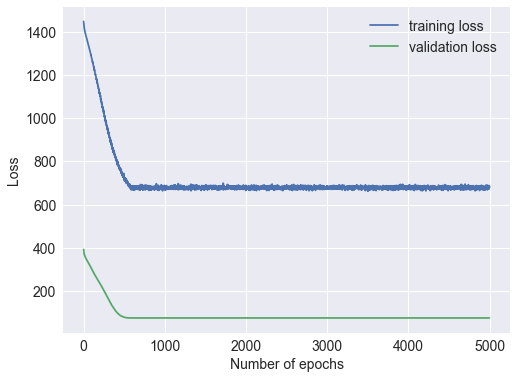

In [38]:
# plot loss and AUC
plt.figure(figsize=(8, 6))
FONT=14
plt.plot(range(num_epochs), training.history['loss'], label='training loss')
plt.plot(range(num_epochs), training.history['val_loss'], label='validation loss')
plt.xlabel('Number of epochs', fontsize=FONT)
plt.ylabel('Loss', fontsize=FONT)
plt.legend(fontsize=FONT)
plt.tick_params(axis='both', which='major', labelsize=FONT)
plt.show()


In [39]:
cols = {(str(score),str(model),str(metric)):[] for score in ["MSE","R^2"] for model in ["train","test"] for metric in ['injuries','str dam', 'str des', 'fatalities', 'average']}

train_pred = np.around(mdl.predict(Xtrain)); train_pred[train_pred<0] = 0
test_pred = np.around(mdl.predict(Xtest)); test_pred[test_pred<0] = 0

train_score = np.around(r2_score(train_pred, ytrain, multioutput='raw_values'),3)
cols[('R^2','train','injuries')].append(train_score[0]); cols[('R^2', 'train', 'str dam')].append(train_score[1])
cols[('R^2','train','str des')].append(train_score[2]); cols[('R^2', 'train', 'fatalities')].append(train_score[3])
cols[('R^2','train','average')].append(round(r2_score(train_pred, ytrain),3))

test_score = np.around(r2_score(test_pred, ytest,multioutput='raw_values'),3)
cols[('R^2','test','injuries')].append(test_score[0]); cols[('R^2','test','str dam')].append(test_score[1])
cols[('R^2','test','str des')].append(test_score[2]); cols[('R^2','test','fatalities')].append(test_score[3])
cols[('R^2','test','average')].append(round(r2_score(test_pred, ytest),3))

train_MSE = np.around(mean_squared_error(ytrain, train_pred,multioutput='raw_values'),3)
cols[('MSE','train','injuries')].append(train_MSE[0]); cols[('MSE', 'train', 'str dam')].append(train_MSE[1])
cols[('MSE','train','str des')].append(train_MSE[2]); cols[('MSE', 'train', 'fatalities')].append(train_MSE[3])
cols[('MSE','train','average')].append(round(mean_squared_error(train_pred, ytrain),3))

test_MSE = np.around(mean_squared_error(ytest, test_pred,multioutput='raw_values'),3)
cols[('MSE','test','injuries')].append(test_MSE[0]); cols[('MSE','test','str dam')].append(test_MSE[1])
cols[('MSE','test','str des')].append(test_MSE[2]); cols[('MSE','test','fatalities')].append(test_MSE[3])
cols[('MSE','test','average')].append(round(mean_squared_error(test_pred, ytest),3))


columns = pd.MultiIndex.from_tuples([col for col in cols])
results_df = pd.DataFrame(cols, columns=columns, index=['DNN'])
#results_df['Model'] = ['DNN']
display(results_df)

MSE                                                                   \
       train                                            test                    
    injuries  str dam   str des fatalities  average injuries str dam  str des   
DNN   28.274  223.048  2433.437      0.444  671.301   15.877  74.266  384.632   

                             R^2                                              \
                           train                                        test   
    fatalities  average injuries str dam str des fatalities average injuries   
DNN      0.059  118.709   -0.694  -1.008  -0.721     -5.809  -2.058    -0.46   

                                        
                                        
    str dam str des fatalities average  
DNN   0.364   0.742     -0.528    0.03

## XGBoost

In [40]:
params = {'booster': ['gbtree', 'gblinear', 'dart'], 'n_estimators': [i for i in range(100, 500, 25)]}
tree_params = {'max_depth':[i for i in range(3,25)]}
for param in params:
    train_r = []
    test_r = []
    train_MSE = []
    test_MSE = []
    for val in tqdm(params[param]):
        input_params = {param:val}
        clf = MultiOutputRegressor(xgb.XGBRegressor(**input_params))
        clf.fit(Xtrain, ytrain)
        train_r.append(round(clf.score(Xtrain, ytrain),3))
        test_r.append(round(clf.score(Xtest, ytest),3))
        train_MSE.append(round(mean_squared_error(ytrain, clf.predict(Xtrain)),3))
        test_MSE.append(round(mean_squared_error(ytest, clf.predict(Xtest)),3))
    print(param+" best value:", params[param][np.argmin(test_MSE)])

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumptio

booster best value: gblinear


C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
  6%|█████▏                                                                             | 1/16 [00:0

C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
 56%|██████████████████████████████████████████████▋                                    | 9/16 [01:37<01:31, 13.05s/it]C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumptio

n_estimators best value: 150


In [41]:
xgboost_mdl = xgb.XGBRegressor(booster='gblinear',n_estimators=150)#100)

## Decision Tree Regressor

In [42]:
params = {'criterion':['mse', 'mae', 'friedman_mse'],
         'max_features':['auto', 'sqrt', 'log2'],
         'splitter':['best', 'random']}
best_params = {}

In [43]:
for param in tqdm(params):
    train_r = []
    test_r = []
    train_MSE = []
    test_MSE = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        clf = MultiOutputRegressor(DecisionTreeRegressor(**test_params))
        clf.fit(Xtrain, ytrain)
        train_r.append(round(clf.score(Xtrain, ytrain),3))
        test_r.append(round(clf.score(Xtest, ytest),3))
        train_MSE.append(round(mean_squared_error(ytrain, clf.predict(Xtrain)),3))
        test_MSE.append(round(mean_squared_error(ytest, clf.predict(Xtest)),3))
    best_params[param] = params[param][np.argmin(test_MSE)]
print(best_params)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [29:13<00:00, 584.63s/it]

{'criterion': 'mae', 'max_features': 'sqrt', 'splitter': 'random'}


In [ ]:
DecisionTreeRegressor(criterion='mae', max_features='sqrt', splitter='random')

## AdaBoost Regressor

In [44]:
params = {'base_estimator':[None, DecisionTreeRegressor(criterion='mse', max_features='auto', splitter='random')],
          'n_estimators':[i for i in range(50, 550, 50)],
          'learning_rate':[1*((10)**(i)) for i in range(-4,3,1)],
          'loss':['linear', 'square', 'exponential']
         }
best_params = {}

In [45]:
for param in tqdm(params):
    train_r = []
    test_r = []
    train_MSE = []
    test_MSE = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        clf = MultiOutputRegressor(AdaBoostRegressor(**test_params))
        clf.fit(Xtrain, ytrain)
        train_r.append(round(clf.score(Xtrain, ytrain),3))
        test_r.append(round(clf.score(Xtest, ytest),3))
        train_MSE.append(round(mean_squared_error(ytrain, clf.predict(Xtrain)),3))
        test_MSE.append(round(mean_squared_error(ytest, clf.predict(Xtest)),3))
    best_params[param] = params[param][np.argmin(test_MSE)]
print(best_params)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [29:32<00:00, 443.21s/it]

{'base_estimator': DecisionTreeRegressor(max_features='auto', splitter='random'), 'n_estimators': 50, 'learning_rate': 0.1, 'loss': 'exponential'}


In [46]:
#AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_features='auto', splitter='random'), n_estimators=50, learning_rate=1, loss='square')
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_features='auto', splitter='random'), n_estimators=50, learning_rate=0.1, loss='exponential')

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_features='auto',
                                                       splitter='random'),
                  learning_rate=1, loss='square')

### MLP

In [75]:
params = {'alpha': [1*((10)**(i)) for i in range(-4,3,1)],
         'learning_rate':['constant', 'invscaling', 'adaptive'],
          'hidden_layer_sizes':[(50,), (50,50), (50,50,50), (100,), (100,100), (100,100,100)]}
best_params = {}

In [76]:
for param in tqdm(params):
    train_r = []
    test_r = []
    train_MSE = []
    test_MSE = []
    for val in tqdm(params[param]):
        test_params = {param:val}
        test_params.update(best_params)
        clf = MultiOutputRegressor(MLPRegressor(random_state=0, max_iter=10000,**test_params))
        clf.fit(Xtrain, ytrain)
        train_r.append(round(clf.score(Xtrain, ytrain),3))
        test_r.append(round(clf.score(Xtest, ytest),3))
        train_MSE.append(round(mean_squared_error(ytrain, clf.predict(Xtrain)),3))
        test_MSE.append(round(mean_squared_error(ytest, clf.predict(Xtest)),3))
    best_params[param] = params[param][np.argmin(test_MSE)]
print(best_params)

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [1:14:36<00:00, 1492.21s/it]

{'alpha': 0.1, 'learning_rate': 'constant', 'hidden_layer_sizes': (100,)}
